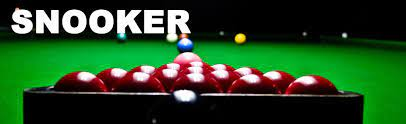
# Computer Vision Project - Snooker Balls Detection 

------

## **Written by** 
- `Liz Lugasi, 313169476`  
- `Sharon Guy, 316582691`  
- `Nati Moshe, 205636731`  
------

## Importing intial requirements

Please make sure to install the following packages to your environment before running this notebook:
- `jupyterlab`  
- `matplotlib`  
- `opencv-python`  

In [1]:
from table_utilities import *
from balls_utilities import *
from colors_ranges import *
from plotting_utilities import *
import warnings
import matplotlib.pyplot as plt
import numpy as np
import cv2

warnings.filterwarnings('ignore')

# Getting 2D homography representation of table top view. 

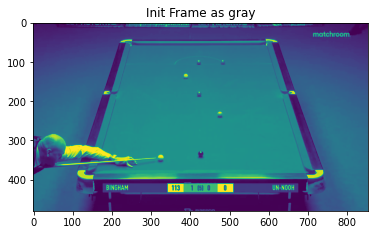

In [2]:
capture = cv2.VideoCapture('snooker.mp4')

_, frame_refference = capture.read()
frame_refference_rgb = cv2.cvtColor(frame_refference, cv2.COLOR_BGR2RGB)
frame_refference_gray = cv2.cvtColor(frame_refference.copy(), cv2.COLOR_BGR2GRAY)
plt.imshow(frame_refference_gray)
plt.title("Init Frame as gray")
plt.show()

#### Find table lines using probabilitic Hough lines:


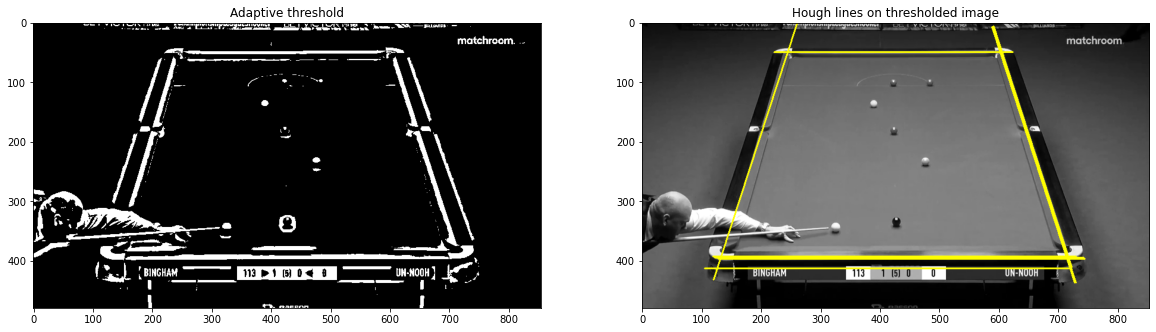

In [3]:
adaptive_th_img = cv2.adaptiveThreshold(frame_refference_gray,255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,21,-10)
table_lines = cv2.HoughLinesP(adaptive_th_img, rho=2,theta=np.pi/20, threshold=600, minLineLength=400,maxLineGap=50) 

# Draw initial hough lines
frame_refference_lines = cv2.cvtColor(frame_refference_gray,cv2.COLOR_GRAY2RGB)
for x1,y1,x2,y2 in table_lines[:,0,:]:
    cv2.line(frame_refference_lines,(x1,y1),(x2,y2),(255,255,0),2)

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(adaptive_th_img,cmap='gray')
plt.title("Adaptive threshold")
plt.subplot(1,2,2)
plt.imshow(frame_refference_lines)
plt.title("Hough lines on thresholded image")
plt.show()

#### Find intersection points of hoguh lines [Used this for help](https://stackoverflow.com/questions/20677795/how-do-i-compute-the-intersection-point-of-two-lines)
        

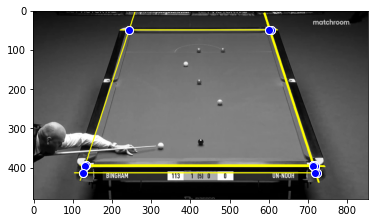

In [4]:
plt.imshow(frame_refference_lines)
intersection_pts = []

for x1,y1,x2,y2 in table_lines[:,0,:]:
    for x3,y3,x4,y4 in table_lines[:,0,:]:
        m1 = abs(((y2-y1)/(x2-x1)))
        m2 = abs(((y4-y3)/(x4-x3)))
        if abs(m1-m2)>0.1:
            intersection_pt = line_intersection(((x1,y1), (x2,y2)), ((x3,y3), (x4,y4)))
            intersection_pts.append(intersection_pt)
            plt.plot(intersection_pt[0],intersection_pt[1],'ob', markeredgecolor='w', markersize=8)

intersection_pts = np.asarray(intersection_pts).astype(np.float32)

#### Cluster intersection points & finding 4 best points

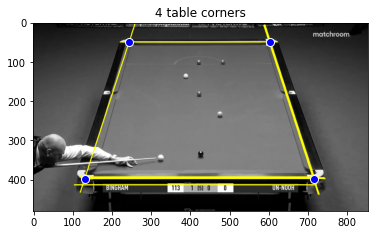

In [5]:
# Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
crt = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1.0)

# Apply KMeans
compactness,labels,table_corners = cv2.kmeans(intersection_pts,K=4,bestLabels=None,criteria=crt, attempts=50,flags=cv2.KMEANS_RANDOM_CENTERS)

# Plot
plot_corners_image(frame_refference_lines = frame_refference_lines,table_corners = table_corners)

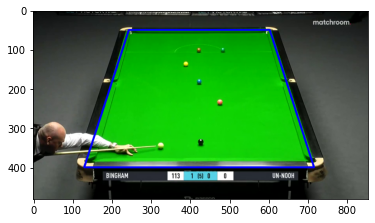

In [6]:
table_corners = np.asarray(table_corners)
table_corners = table_corners.astype(np.int32).reshape(-1,1,2)

# Draw table borders on reference frame
frame_refference_rgb_borders = frame_refference_rgb.copy()
frame_refference_rgb_borders = draw_table_borders(frame_refference_rgb_borders, table_corners)
plt.imshow(frame_refference_rgb_borders)
plt.show()

#### Find homography between 4 points

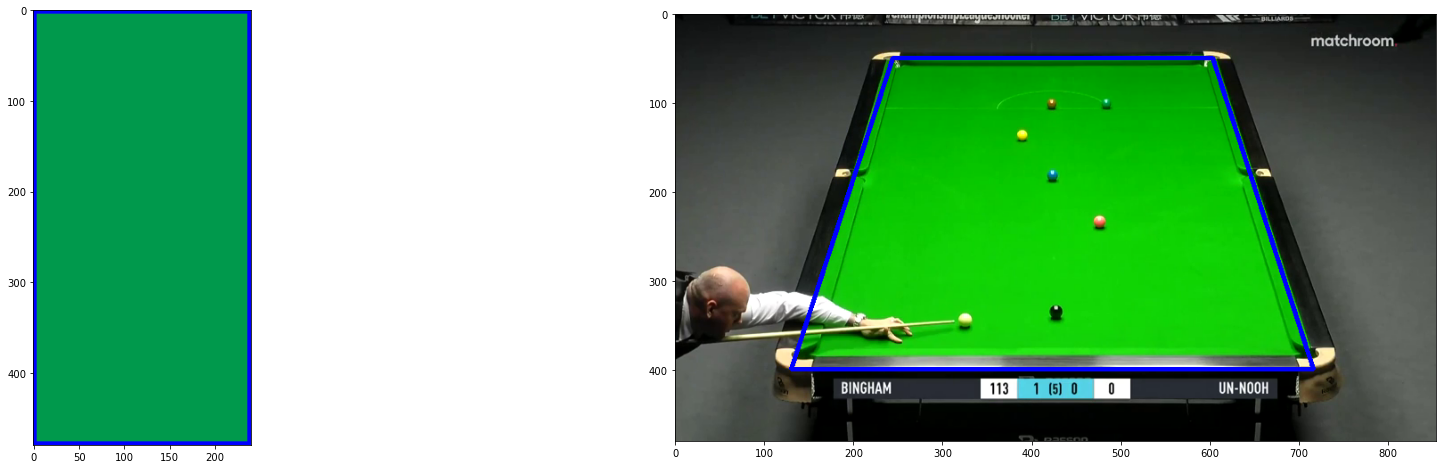

In [7]:
top_view = create_2d_top_view(frame_refference_rgb)

# Define 4 corners points of 2D-top-view
h=frame_refference_rgb.shape[0]
w=int(h/2)
corners_table_2d = np.int32([ [0,h-1],[w-1,0],[w-1,h-1],[0,0] ]).reshape(-1,1,2)
table_corners = np.int32(table_corners).reshape(-1,1,2)

plt.figure(figsize=(30,8))
plt.subplot(1,2,2)
plt.imshow(frame_refference_rgb_borders)
plt.subplot(1,2,1)
plt.imshow(top_view)
plt.show()

## Part 2: Find snooker balls on reference frame
####   High level:
####    1. Convert image to HSV
####    2. Use Hue value to identify each ball's location (by ball color)

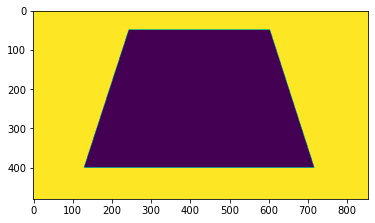

In [8]:
# find homography of 4 table corners - real to 2D top view
M, mask = cv2.findHomography(table_corners, corners_table_2d, cv2.RANSAC,5.0)

# Create a mask of table area - area to search for balls
table_mask = np.zeros_like(adaptive_th_img)
table_mask = table_mask + 255
table_corners_mask = np.int32([table_corners[3],table_corners[1],table_corners[2],table_corners[0]]).reshape(-1,1,2)
table_mask = cv2.fillPoly(table_mask,[table_corners_mask],(0,0,0))
plt.imshow(table_mask)

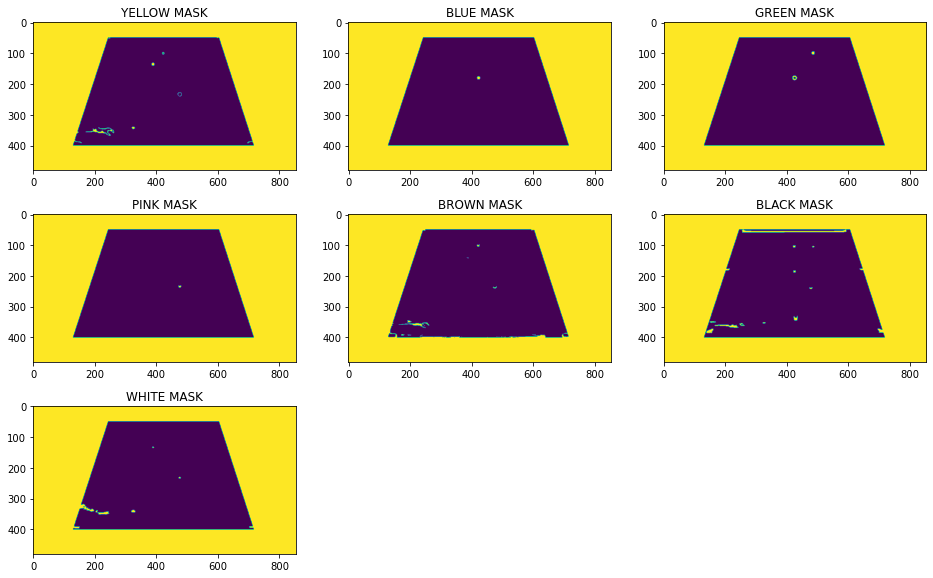

In [9]:
# Bluring Image for better detection
img_filtered = cv2.GaussianBlur(frame_refference_rgb,(0,0),2)
F_ref_hsv = cv2.cvtColor(img_filtered, cv2.COLOR_RGB2HSV)

# Create masks refferences for balls
balls_references = create_balls_masks(
    table_mask=table_mask,
    frame_refference_hsv=cv2.cvtColor(cv2.GaussianBlur(frame_refference_rgb,(0,0),2), cv2.COLOR_RGB2HSV)
)

# Plotting masks for balls
plot_masks_for_balls(balls_references)

In [10]:
balls_list = []

# Getting balls locations
yellow_loc = find_ball(balls_references[0], balls_list, table_corners=table_corners)
blue_loc = find_ball( balls_references[1], balls_list, table_corners=table_corners)
green_loc = find_ball(balls_references[2], balls_list, table_corners=table_corners)
pink_loc = find_ball(balls_references[3], balls_list, table_corners=table_corners)
brown_loc = find_ball(balls_references[4], balls_list, table_corners=table_corners)
black_loc = find_ball(balls_references[5], balls_list, table_corners=table_corners)
white_loc = find_ball(balls_references[6], balls_list, table_corners=table_corners)

black_ref_loc = black_loc

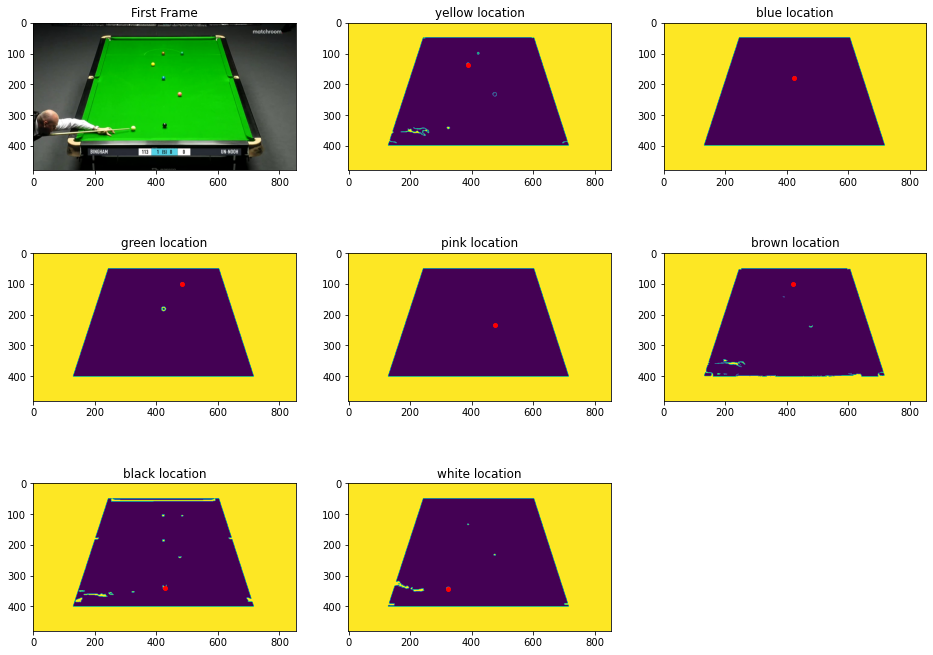

In [11]:
plot_balls_locations(frame_refference_rgb = frame_refference_rgb,
    balls_references = balls_references,yellow_loc = yellow_loc,blue_loc = blue_loc,green_loc = green_loc,
    pink_loc = pink_loc,brown_loc = brown_loc,black_loc = black_loc,white_loc = white_loc,
)

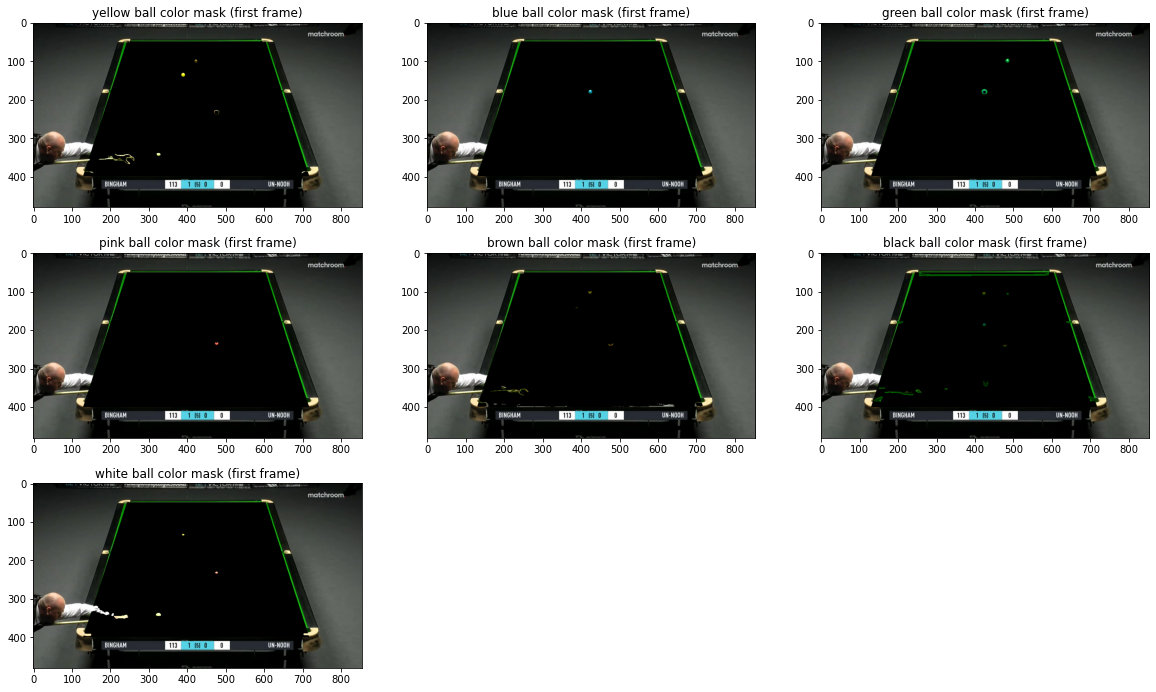

In [12]:
yellow_ref, blue_ref, green_ref, pink_ref, brown_ref, black_ref, white_ref = get_masks_for_balls(
    frame_refference_rgb = frame_refference_rgb,
    balls_references = balls_references
)


plot_frame_with_masks_of_balls(
    yellow_ref, blue_ref, green_ref, pink_ref, brown_ref, black_ref, white_ref
)

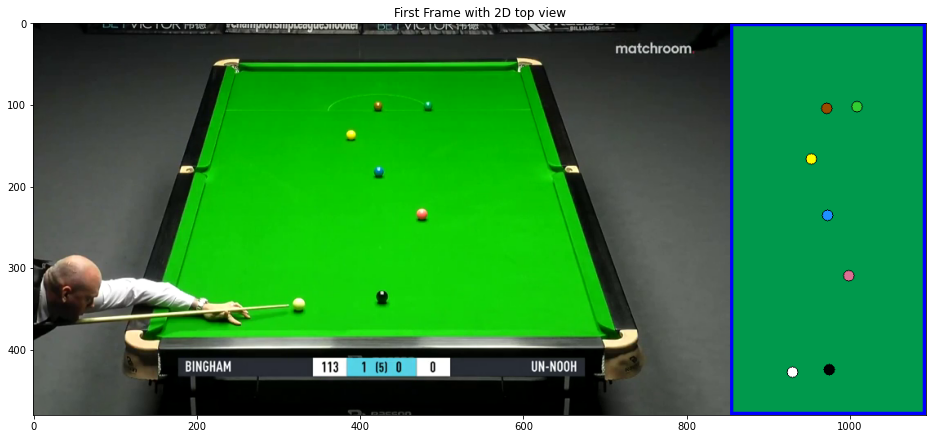

In [13]:
# Create 2D top view and mark balls location (refernce frame)
top_view = create_2d_top_view(frame_refference_rgb)
for idx,ball_loc in enumerate(balls_list):
    ball_loc = np.int32([ ball_loc ]).reshape(-1,1,2)
    ball_loc = ball_loc.astype(np.float32)
    
    if idx==0:
        color = YELLOW_BALL_COLOR
    elif idx==1:
        color = BLUE_BALL_COLOR
    elif idx==2:
        color = GREEN_BALL_COLOR
    elif idx==3:
        color = PINK_BALL_COLOR
    elif idx==4:
        color = BROWN_BALL_COLOR
    elif idx==5:
        color = BLACK_BALL_COLOR
    elif idx==6:
        color = WHITE_BALL_COLOR

    dst = cv2.perspectiveTransform(ball_loc.astype(np.float),M)
    dst = np.int32(dst)

    for idx,ball in enumerate(dst):
        cv2.circle(top_view,(ball[0][0],ball[0][1]),6,color,-1) #colored circle
        cv2.circle(top_view,(ball[0][0],ball[0][1]),7,(0,0,0),1) #black outline

        
plt.figure(figsize=(16,20))
first_frame_to2d = np.concatenate((frame_refference_rgb, top_view), axis=1)
plt.imshow(first_frame_to2d)
plt.title("First Frame with 2D top view")
plt.show()

## Track balls IRT
----

In [14]:
holes = []
for idx,corner in enumerate(corners_table_2d):
    holes.append(((corners_table_2d[idx][0][0],corners_table_2d[idx][0][1]), 21))
holes.append((((int(corners_table_2d[0][0][0])),int(corners_table_2d[0][0][1]/2)),11))
holes.append((((int(corners_table_2d[2][0][0])),int(corners_table_2d[2][0][1]/2)),11))

In [15]:
def is_ball_in_hole(ball_loc):
    for hole, rad in holes:
        if hole[0] - rad < ball_loc[0][0][0] < hole[0] + rad:
            if hole[1] - rad < ball_loc[0][0][1] < hole[1] + rad:
                return True
    return False

def track_ball(
    pre_frame, curr_frame, prev_loc, top_view, color_range,
    ball_color, s_range=[50,255], v_range=[50,255], c=0):

    # Optical flow params
    lk_params = dict( winSize  = (20,20),
              maxLevel = 5,
              criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 50, 0.00003))  
    
    curr_frame_hsv = cv2.cvtColor(curr_frame, cv2.COLOR_RGB2HSV)
    if color_range==(0,0): #black
        if c>235:
            dst = cv2.perspectiveTransform(black_ref_loc.astype(np.float),M)
            dst = np.int32(dst)
            top_view = paint_ball_on_view(top_view,black_ball_color,dst)
            return top_view, curr_frame, black_ref_loc
        else:
            mask_curr = mask_black_ball(curr_frame_hsv,table_mask=table_mask)
    elif color_range==(255,255):#white
        mask_curr = mask_white_ball_for_tracking(curr_frame_hsv,table_mask=table_mask)
        if prev_loc[0][0][1]<150:  # if ball is "far" dilate the mask for better detection of ball
            kernel = np.ones((5,5),np.uint8)
            mask_curr = cv2.dilate(mask_curr, kernel)
    else: #color
        mask_curr = mask_by_color_range(curr_frame_hsv, color_range, s_range, v_range,table_mask=table_mask)
        
    if prev_loc is None:
        return top_view,curr_frame,None  
        
    curr_frame = mask_balls(mask_curr, curr_frame)
    # Optical Flow
    ball_new_loc, status, err = cv2.calcOpticalFlowPyrLK(pre_frame, curr_frame, prev_loc, None, **lk_params)
    
    dst = cv2.perspectiveTransform(ball_new_loc.astype(np.float),M)
    dst = np.int32(dst)
    prev_loc_transform = cv2.perspectiveTransform(prev_loc.astype(np.float),M)
    prev_loc_transform = np.int32(prev_loc_transform)

    # If ball location is near a hole - remove it and set location None
    if is_ball_in_hole(dst):
        ball_new_loc = None
        return top_view, curr_frame, ball_new_loc
    
    # If we got here and ball's status is 0, probably ball is blocked by view. Set the current location to last known location.
    if status[0] == 0:
        ball_new_loc = prev_loc

    # Draw the ball on the top view at current location
    top_view = paint_ball_on_view(top_view,ball_color,dst)
    
    return top_view, curr_frame, ball_new_loc

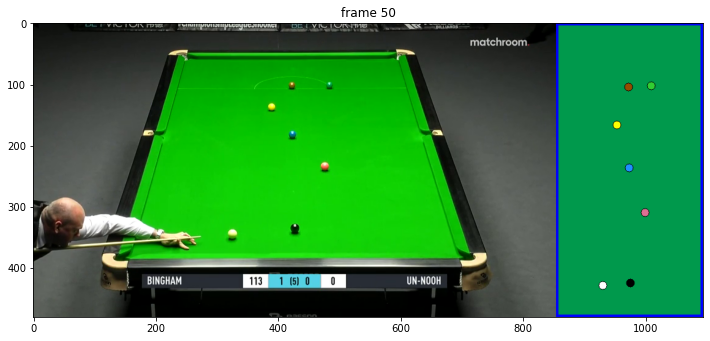

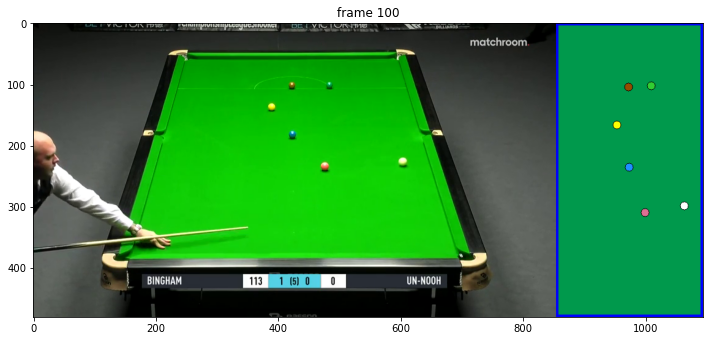

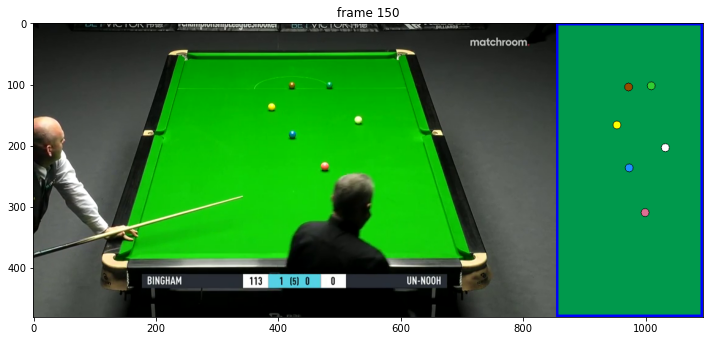

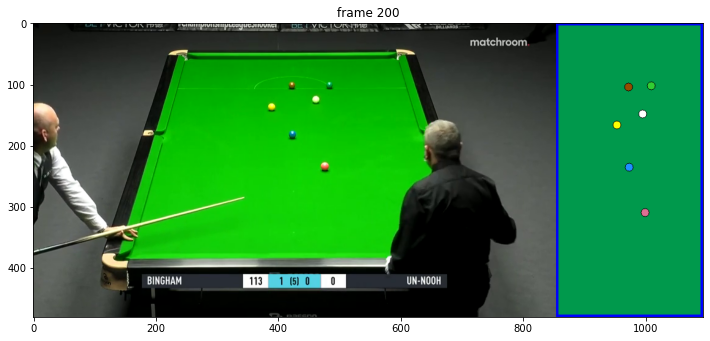

NameError: name 'black_ball_color' is not defined

In [16]:
capture = cv2.VideoCapture('snooker.mp4')
FPS = capture.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
H = int(first_frame_to2d.shape[0])
W = int(first_frame_to2d.shape[1])
out = cv2.VideoWriter('snooker_2D.mp4',fourcc, FPS, (W,H))


# First frame - set previous to reference (0)
F_prev_yellow = yellow_ref
F_prev_blue = blue_ref
F_prev_green = green_ref
F_prev_pink = pink_ref
F_prev_brown = brown_ref
F_prev_black = black_ref
F_prev_white = white_ref


counter = 0
while(1):
    ret,F_current = capture.read()
    
    if ret==True:
        top_view = create_2d_top_view(frame_refference_rgb)
        F_current_rgb = cv2.cvtColor(F_current, cv2.COLOR_BGR2RGB)        
        F_current_rgb = cv2.GaussianBlur(F_current_rgb,(0,0),2)
        F_current_rgb_wh = cv2.GaussianBlur(F_current_rgb,(5,5),0)
        
        # Track yellow ball
        top_view_curr, yellow_curr_frame, yellow_new_loc = track_ball(
            F_prev_yellow, F_current_rgb, yellow_loc, top_view, YELLOW_H_RANGE, YELLOW_BALL_COLOR)
        
        # Track blue ball
        top_view_curr, blue_curr_frame, blue_new_loc = track_ball(
            F_prev_blue, F_current_rgb, blue_loc, top_view, BLUE_H_RANGE, BLUE_BALL_COLOR)

        # Track green ball
        top_view_curr, green_curr_frame, green_new_loc = track_ball(
            F_prev_green, F_current_rgb, green_loc, top_view, GREEN_H_RANGE, GREEN_BALL_COLOR)

        # Track pink ball
        top_view_curr, pink_curr_frame, pink_new_loc = track_ball(
            F_prev_pink, F_current_rgb, pink_loc, top_view, PINK_H_RANGE, PINK_BALL_COLOR, PINK_SAT_RANGE, PINK_V_RANGE)

        # Track brown ball
        top_view_curr, brown_curr_frame, brown_new_loc = track_ball(
            F_prev_brown, F_current_rgb, brown_loc, top_view, BROWN_H_RANGE, BROWN_BALL_COLOR, BROWN_SAT_RANGE, BROWN_V_RANGE)
    
        # Track black ball
        top_view_curr, black_curr_frame, black_new_loc = track_ball(
            F_prev_black, F_current_rgb, black_loc, top_view, (0,0), BLACK_BALL_COLOR,(0,0),(0,0), counter)
            
        # Track white ball
        top_view_curr, white_curr_frame, white_new_loc = track_ball(
            F_prev_white, F_current_rgb_wh, white_loc, top_view, (255,255), WHITE_BALL_COLOR)
            

        # Show frame and its top view and write to video file
        top_view_bgr = cv2.cvtColor(top_view, cv2.COLOR_RGB2BGR)        
        merged_img = np.concatenate((F_current, top_view_bgr), axis=1)
        cv2.imshow('Snooker Game with Top View', merged_img)
        out.write(merged_img)
        
        # update previous frame & previous ball location for optical flow
        F_prev_yellow = yellow_curr_frame
        yellow_loc = yellow_new_loc
        F_prev_blue = blue_curr_frame
        blue_loc = blue_new_loc
        F_prev_green = green_curr_frame
        green_loc = green_new_loc
        F_prev_pink = pink_curr_frame
        pink_loc = pink_new_loc
        F_prev_brown = brown_curr_frame
        brown_loc = brown_new_loc
        F_prev_black = black_curr_frame
        black_loc = black_new_loc
        F_prev_white = white_curr_frame
        white_loc = white_new_loc
        counter+=1
        
        # Plots the frame every 50 frames.
        if (counter%50)==0:
            plt.figure(figsize=(12,12))
            plt.imshow(cv2.cvtColor(merged_img, cv2.COLOR_BGR2RGB))
            plt.title(f'frame {counter}')
            plt.show()
            
        k = cv2.waitKey(1) & 0xff
        if k == 27:
            break
    else:
        break

capture.release()
out.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

Please note - the above error is not an actual error, it is because the black ball exits the game in the beginning 